Import python packages

In [27]:
import os
import math
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Take the parsed .shr files (in .csv format)

In [28]:
# Taken when camera is off
normal_data = "clearwrite_captured_SWEEP_REC_2024-05-18 20h09m13s_cam_off.csv"
normal_file_path = os.path.join('output_file', normal_data)

normal = pd.read_csv(normal_file_path, header=None)
normal.head()

,0,1,2,3,4,5,6,7,8,9,...,6547,6548,6549,6550,6551,6552,6553,6554,6555,6556
0,2024-05-18 20:09:13.834625,-114.826958,-115.269852,-116.024361,-116.723000,-117.017418,-117.019386,-117.083138,-117.210640,-117.113495,...,-113.282715,-111.501190,-110.096581,-109.248451,-108.725166,-108.481735,-108.706665,-109.488808,-110.503487,-111.488007
1,2024-05-18 20:09:14.208616,-114.259499,-114.648773,-115.484390,-116.923485,-118.149460,-118.185081,-117.563507,-116.602753,-115.502129,...,-111.525482,-111.675964,-111.795281,-111.839989,-112.088020,-112.608688,-113.057526,-113.102852,-112.781227,-112.288559
2,2024-05-18 20:09:14.308370,-115.616699,-115.946899,-116.737312,-117.449471,-117.553909,-117.254921,-117.071632,-117.062843,-117.189766,...,-113.736496,-114.008469,-113.822891,-113.639900,-113.688324,-113.931023,-114.241989,-114.588623,-114.871849,-114.908997
3,2024-05-18 20:09:14.390648,-112.826714,-112.472832,-112.364899,-112.478981,-113.021820,-113.856125,-114.576477,-115.127808,-115.702309,...,-110.664589,-110.155769,-109.856209,-109.720459,-109.897194,-110.247246,-110.424553,-110.505295,-110.960274,-112.027046
4,2024-05-18 20:09:14.490387,-112.913010,-112.273941,-111.626732,-111.528290,-111.841286,-112.031876,-112.219757,-112.942886,-114.063873,...,-116.735657,-115.917351,-114.132362,-112.538269,-111.514366,-110.896561,-110.432480,-110.160400,-110.336739,-110.796547


In [29]:
# Taken when camera is on
anomaly_data = "clearwrite_captured_SWEEP_REC_2024-05-18 20h23m07s_cam_on.csv"
anomaly_file_path = os.path.join('output_file', anomaly_data)

anomaly = pd.read_csv(anomaly_file_path, header=None)
anomaly.head()

,0,1,2,3,4,5,6,7,8,9,...,6547,6548,6549,6550,6551,6552,6553,6554,6555,6556
0,2024-05-18 20:23:07.207691,-113.476067,-113.212006,-112.930351,-112.559303,-112.535805,-113.227631,-114.592934,-115.630669,-115.185478,...,-118.459549,-116.973358,-116.018478,-115.803040,-116.100426,-116.602562,-117.194397,-117.588593,-116.781746,-114.642510
1,2024-05-18 20:23:07.344072,-110.820221,-111.468933,-112.695816,-114.253075,-115.434593,-115.844505,-115.839142,-115.655182,-115.448685,...,-110.299477,-109.778786,-109.800713,-110.040863,-110.312264,-110.394669,-109.792145,-108.660210,-107.795555,-107.454254
2,2024-05-18 20:23:07.446605,-113.803711,-114.741013,-115.786377,-117.132034,-118.460465,-119.013740,-118.654434,-117.523315,-116.132095,...,-113.302795,-113.462730,-114.446709,-115.618492,-115.339996,-113.800072,-112.223709,-111.161522,-110.688553,-110.555168
3,2024-05-18 20:23:07.558867,-116.701439,-116.101311,-115.526505,-115.680817,-116.465729,-117.507324,-118.163849,-117.233124,-115.227585,...,-110.108993,-110.032959,-110.403664,-110.732658,-110.869713,-111.213226,-112.232849,-114.026566,-115.734512,-116.035599
4,2024-05-18 20:23:07.631086,-113.011581,-113.363686,-114.186562,-115.316856,-116.252563,-116.562309,-116.428177,-116.030739,-115.377976,...,-112.501869,-111.801392,-111.500664,-111.109558,-110.539925,-110.195564,-110.347153,-110.866791,-111.480774,-112.137505


#### Data Pre-Processing

In [30]:
START_FREQ  = 455500000         # 455.5 MHz 
END_FREQ    = 465500000         # 465.5 MHz
FREQ_BIN_SIZE = 78124.97688     # ~78.125 KHz

def preprocess_dataframe(df):
    # Separate timestamp column from the data
    timestamps = df.iloc[:, 0]
    data = df.iloc[:, 1:]
    num_columns = len(data.columns)
    frequency_values = [START_FREQ + i * FREQ_BIN_SIZE for i in range(num_columns)]
    # Set data timestamp to be index column
    data.index = pd.to_datetime(timestamps)
    data.index.name = 'Timestamp'
    # Name subsequent columns based on the frequency
    data.columns = frequency_values
    return data

Pre-process normal dataframe

In [31]:
normal_df = preprocess_dataframe(normal)
normal_df.head()

,4.555000e+08,4.555781e+08,4.556562e+08,4.557344e+08,4.558125e+08,4.558906e+08,4.559687e+08,4.560469e+08,4.561250e+08,4.562031e+08,...,9.669061e+08,9.669842e+08,9.670623e+08,9.671405e+08,9.672186e+08,9.672967e+08,9.673748e+08,9.674530e+08,9.675311e+08,9.676092e+08
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-18 20:09:13.834625,-114.826958,-115.269852,-116.024361,-116.723000,-117.017418,-117.019386,-117.083138,-117.210640,-117.113495,-116.862602,...,-113.282715,-111.501190,-110.096581,-109.248451,-108.725166,-108.481735,-108.706665,-109.488808,-110.503487,-111.488007
2024-05-18 20:09:14.208616,-114.259499,-114.648773,-115.484390,-116.923485,-118.149460,-118.185081,-117.563507,-116.602753,-115.502129,-114.627976,...,-111.525482,-111.675964,-111.795281,-111.839989,-112.088020,-112.608688,-113.057526,-113.102852,-112.781227,-112.288559
2024-05-18 20:09:14.308370,-115.616699,-115.946899,-116.737312,-117.449471,-117.553909,-117.254921,-117.071632,-117.062843,-117.189766,-117.511459,...,-113.736496,-114.008469,-113.822891,-113.639900,-113.688324,-113.931023,-114.241989,-114.588623,-114.871849,-114.908997
2024-05-18 20:09:14.390648,-112.826714,-112.472832,-112.364899,-112.478981,-113.021820,-113.856125,-114.576477,-115.127808,-115.702309,-115.828545,...,-110.664589,-110.155769,-109.856209,-109.720459,-109.897194,-110.247246,-110.424553,-110.505295,-110.960274,-112.027046
2024-05-18 20:09:14.490387,-112.913010,-112.273941,-111.626732,-111.528290,-111.841286,-112.031876,-112.219757,-112.942886,-114.063873,-114.671692,...,-116.735657,-115.917351,-114.132362,-112.538269,-111.514366,-110.896561,-110.432480,-110.160400,-110.336739,-110.796547


Pre-process anomaly data as well

In [32]:
anomaly_df = preprocess_dataframe(anomaly)
anomaly_df.head()

,4.555000e+08,4.555781e+08,4.556562e+08,4.557344e+08,4.558125e+08,4.558906e+08,4.559687e+08,4.560469e+08,4.561250e+08,4.562031e+08,...,9.669061e+08,9.669842e+08,9.670623e+08,9.671405e+08,9.672186e+08,9.672967e+08,9.673748e+08,9.674530e+08,9.675311e+08,9.676092e+08
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-18 20:23:07.207691,-113.476067,-113.212006,-112.930351,-112.559303,-112.535805,-113.227631,-114.592934,-115.630669,-115.185478,-114.222267,...,-118.459549,-116.973358,-116.018478,-115.803040,-116.100426,-116.602562,-117.194397,-117.588593,-116.781746,-114.642510
2024-05-18 20:23:07.344072,-110.820221,-111.468933,-112.695816,-114.253075,-115.434593,-115.844505,-115.839142,-115.655182,-115.448685,-115.549141,...,-110.299477,-109.778786,-109.800713,-110.040863,-110.312264,-110.394669,-109.792145,-108.660210,-107.795555,-107.454254
2024-05-18 20:23:07.446605,-113.803711,-114.741013,-115.786377,-117.132034,-118.460465,-119.013740,-118.654434,-117.523315,-116.132095,-115.140213,...,-113.302795,-113.462730,-114.446709,-115.618492,-115.339996,-113.800072,-112.223709,-111.161522,-110.688553,-110.555168
2024-05-18 20:23:07.558867,-116.701439,-116.101311,-115.526505,-115.680817,-116.465729,-117.507324,-118.163849,-117.233124,-115.227585,-113.646500,...,-110.108993,-110.032959,-110.403664,-110.732658,-110.869713,-111.213226,-112.232849,-114.026566,-115.734512,-116.035599
2024-05-18 20:23:07.631086,-113.011581,-113.363686,-114.186562,-115.316856,-116.252563,-116.562309,-116.428177,-116.030739,-115.377976,-114.716995,...,-112.501869,-111.801392,-111.500664,-111.109558,-110.539925,-110.195564,-110.347153,-110.866791,-111.480774,-112.137505


#### Visualization

Visualize normal_df's channel power at five multiple timestamps

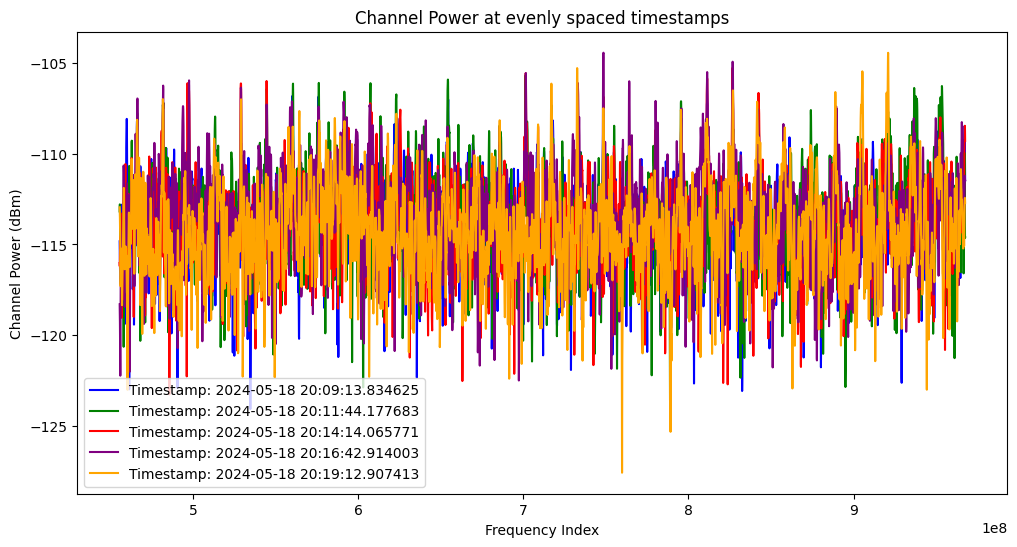

In [33]:
# Define the number of rows to plot
num_rows_to_plot = 5

# Select evenly spaced timestamps
timestamps = normal_df.index[::math.ceil(normal_df.shape[0] / num_rows_to_plot)]

# Select rows at the specified timestamps
selected_rows = normal_df.loc[timestamps]

# Define colors for each line
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Visualize the time-series capture
plt.figure(figsize=(12, 6))

# Plot each selected row with a different color and label
for i, (timestamp, values) in enumerate(selected_rows.iterrows()):
    plt.plot(values, label='Timestamp: {}'.format(timestamp), color=colors[i])

plt.title('Channel Power at evenly spaced timestamps')
plt.xlabel('Frequency Index')
plt.ylabel('Channel Power (dBm)')
plt.legend()
plt.show()


Visualize anomaly_df's channel power at five multiple timestamps

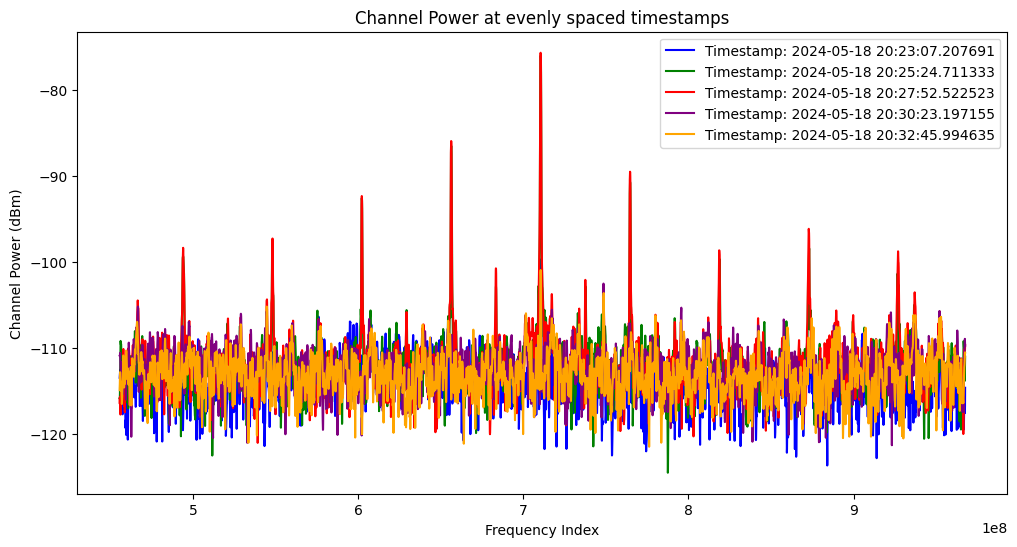

In [34]:
# Define the number of rows to plot
num_rows_to_plot = 5

# Select evenly spaced timestamps
timestamps = anomaly_df.index[::math.ceil(anomaly_df.shape[0] / num_rows_to_plot)]

# Select rows at the specified timestamps
selected_rows = anomaly_df.loc[timestamps]

# Define colors for each line
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Visualize the time-series capture
plt.figure(figsize=(12, 6))

# Plot each selected row with a different color and label
for i, (timestamp, values) in enumerate(selected_rows.iterrows()):
    plt.plot(values, label='Timestamp: {}'.format(timestamp), color=colors[i])

plt.title('Channel Power at evenly spaced timestamps')
plt.xlabel('Frequency Index')
plt.ylabel('Channel Power (dBm)')
plt.legend()
plt.show()


Take max channel power at each frequencies for every 10 seconds

In [35]:
def aggregate_samples(dfa, t=10):
    # Calculate the number of rows to keep
    num_rows_to_keep = (len(dfa) // t) * t
    # Truncate the DataFrame to keep only the rows that can be reshaped into groups of t
    truncated_dfa = dfa.iloc[:num_rows_to_keep]
    # Reset the index temporarily to use integer indexing
    dfa_reset = truncated_dfa.reset_index()
    # Reshape the data into groups of t observations
    grouped_data = dfa_reset.iloc[:, 1:].values.reshape(-1, t, dfa.shape[1])
    # Calculate the lowest negative value for each group
    min_values = grouped_data.min(axis=1)
    # Convert the result back to a DataFrame
    min_values_dfa = pd.DataFrame(min_values, columns=dfa.columns)
    # Get the latest timestamp for each group of t observations
    latest_timestamps = dfa_reset.groupby(dfa_reset.index // t)['Timestamp'].max()
    # Insert the latest timestamps into the resulting DataFrame
    min_values_dfa.insert(0, 'Timestamp', latest_timestamps)
    return min_values_dfa


In [36]:
# Aggregate data every t=10
anomaly_dfa = aggregate_samples(dfa=anomaly_df, t=10)
anomaly_dfa.shape

(1000, 6557)

In [37]:
# Aggregate data every t=10
normal_dfa = aggregate_samples(dfa=normal_df, t=10)
normal_dfa.shape

(1000, 6557)

In [38]:
anomaly_dfa['IsAnomaly'] = 1
anomaly_dfa.head()

,Timestamp,455500000.0,455578124.97688,455656249.95376,455734374.93064,455812499.90752,455890624.8844,455968749.86128,456046874.83816,456124999.81504,...,966984223.63336,967062348.61024,967140473.58712,967218598.564,967296723.54088,967374848.51776,967452973.49464,967531098.47152,967609223.4484,IsAnomaly
0,2024-05-18 20:23:08.145524,-116.743431,-116.678459,-116.541145,-117.132034,-118.460465,-119.013740,-118.654434,-117.523315,-116.132095,...,-116.973358,-116.018478,-115.803040,-116.100426,-116.602562,-117.194397,-117.588593,-116.781746,-116.035599,1
1,2024-05-18 20:23:09.145851,-117.429855,-117.459038,-117.224815,-116.078857,-115.668221,-115.375221,-115.908920,-117.299431,-118.178513,...,-113.957329,-113.764221,-113.486092,-113.048737,-112.571869,-113.026222,-111.991150,-112.108505,-111.810204,1
2,2024-05-18 20:23:10.061385,-117.878990,-118.563667,-116.494759,-115.179596,-115.584534,-115.728020,-115.270798,-115.646835,-117.429161,...,-115.269608,-116.500709,-116.407974,-115.313454,-114.027657,-113.015083,-112.771141,-112.888153,-113.407501,1
3,2024-05-18 20:23:10.993359,-116.067055,-116.944824,-116.032753,-117.426781,-118.416245,-119.015572,-120.101143,-118.720276,-117.092934,...,-114.468590,-114.349060,-113.994598,-114.025909,-114.266632,-115.041290,-115.222107,-114.784149,-114.310410,1
4,2024-05-18 20:23:11.876029,-114.896774,-114.992294,-113.610458,-113.320290,-114.253624,-115.160179,-115.743011,-117.599930,-119.333885,...,-114.957313,-114.963600,-114.110641,-113.022774,-112.893875,-113.145119,-114.743111,-115.370155,-114.943481,1


In [39]:
# Merge normal data with anomaly data
combined_data = pd.concat([normal_dfa, anomaly_dfa.drop(columns=['IsAnomaly'])]).drop(columns=['Timestamp'])
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 999
Columns: 6556 entries, 455500000.0 to 967609223.4484
dtypes: float64(6556)
memory usage: 100.1 MB


In [40]:
combined_data.sample()

,4.555000e+08,4.555781e+08,4.556562e+08,4.557344e+08,4.558125e+08,4.558906e+08,4.559687e+08,4.560469e+08,4.561250e+08,4.562031e+08,...,9.669061e+08,9.669842e+08,9.670623e+08,9.671405e+08,9.672186e+08,9.672967e+08,9.673748e+08,9.674530e+08,9.675311e+08,9.676092e+08
8,-119.231911,-118.59256,-117.74546,-116.705063,-115.513687,-114.781014,-114.978256,-115.703476,-115.491333,-116.281273,...,-116.477547,-116.668419,-116.611305,-117.011887,-117.100594,-116.519524,-114.867561,-113.890991,-113.437111,-112.793549


#### Trained combined data

In [41]:
# Extract values from combine data
X = combined_data.values
# Label the data (0 for normal, 1 for anomalies)
y = np.concatenate([np.zeros(len(normal_dfa)), np.ones(len(anomaly_dfa))])  

In [42]:
# Step 2: Split data into training and testing sets
X_train_t10, X_test_t10, y_train_t10, y_test_t10 = train_test_split(X, y, test_size=0.2, random_state=42)

[Optional] Save data used for training and testing

In [43]:
# Create a folder named 'train_data' if it doesn't exist
train_data_folder = 'train_data'
if not os.path.exists(train_data_folder):
    os.makedirs(train_data_folder)

# Save X_train, X_test, y_train, and y_test as text files in 'train_data' folder
np.savetxt(os.path.join(train_data_folder, 'X_train_t10.txt'), X_train_t10)
np.savetxt(os.path.join(train_data_folder, 'X_test_t10.txt'), X_test_t10)
np.savetxt(os.path.join(train_data_folder, 'y_train_t10.txt'), y_train_t10)
np.savetxt(os.path.join(train_data_folder, 'y_test_t10.txt'), y_test_t10)

In [48]:
# Step 3: Feature Engineering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_t10)
X_test_scaled = scaler.transform(X_test_t10)

# Save the scaler for later use in real-time data normalization
joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

In [45]:
# Step 4: Model Selection and Training
model = IsolationForest(contamination='auto', random_state=42)  # contamination is the proportion of outliers
model.fit(X_train_scaled)

IsolationForest(random_state=42)

In [46]:
# Step 5: Model Evaluation
predictions = model.predict(X_test_scaled)
predictions[predictions == 1] = 0  # Inliers
predictions[predictions == -1] = 1  # Outliers

In [26]:
print(classification_report(y_test_t10, predictions))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       199
         1.0       1.00      0.00      0.01       201

    accuracy                           0.50       400
   macro avg       0.75      0.50      0.34       400
weighted avg       0.75      0.50      0.34       400



#### Save generated model for deployment

In [47]:
# Create the directory if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Step 6: Save the trained model
model_path = os.path.join(models_dir, 'isolation_forest_model.pkl')
joblib.dump(model, model_path)

['models\\isolation_forest_model.pkl']